In [1]:
import torch
import os

print(torch.cuda.is_available())
print(torch.backends.mps)

if torch.cuda.is_available():
    device = torch.device('cuda')
    # get number of cuda devices
    print(f"devices: {torch.cuda.device_count()}")
    print(f"device:  {torch.cuda.get_device_name()}")
    print(f"device0: {torch.cuda.get_device_properties(0)}")
    print(f"{torch.cuda.memory_summary()}")
elif torch.backends.mps is not None:
    device = torch.device('mps')
    print(f"{torch.mps.current_allocated_memory()}")
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
else:
    device = torch.device('cpu')
    # print a warning that cpu is being used
    print("Warning: Running on CPU. This will be slow.")
print(f"{device}")

True
<module 'torch.backends.mps' from 'C:\\Users\\joeya\\anaconda3\\envs\\py38-ITS520-Project\\lib\\site-packages\\torch\\backends\\mps\\__init__.py'>
devices: 1
device:  NVIDIA GeForce RTX 3080
device0: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080', major=8, minor=6, total_memory=10239MB, multi_processor_count=68)
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |

## Architecture

In [2]:
import torch.nn as nn
from torch.nn import functional as F

In [3]:
class Head(nn.Module):

    def __init__(self, head_size, block_size, n_embd, dropout):
        super().__init__()
        
        self.key   = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.query = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.value = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]

        tril_def = torch.tril( torch.ones(block_size, block_size) )  ## [40, 40]
        
        self.register_buffer(
                  'tril', 
                  tril_def
               )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        B, T, E = x.shape   ## [batch_size, 40, 512]
        
        k = self.key(   x )            ## k = (B, T, 64)
        q = self.query( x )            ## q = (B, T, 64)

        E2 = 64     ## I think this is 64 and not 512
        ## (B, T, E) @ (B, E, T)  -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * E2 ** -0.5        
        
        wei = wei.masked_fill(
                      self.tril[:T, :T] == 0, 
                      float('-inf')
        )   
        
        ## (B, T, T)
        wei = F.softmax( wei, dim= -1 )         ## (B, T, T)
        wei = self.dropout(   wei   )
        
        ## perform weighted aggregation of values
        
        v   = self.value(  x  )   ## x = (B, 40, E)
        out = wei @ v             ## (B, T, T) @ (B, T, 64) -> (B, T, 64)
        
        return out
        

In [4]:
class FeedForward(nn.Module):

    def __init__(self, n_embd, dropout):         ## 512
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),      ## [512, 4*512]
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),      ## [4*512, 512]
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)

In [5]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, head_size, block_size, n_embd, dropout):    ## (8, 64)
        super().__init__()
        self.heads = nn.ModuleList(  [ Head(head_size, block_size, n_embd, dropout) for _ in range(n_head) ] )
        self.proj  = nn.Linear(n_embd, n_embd)   ## 512, 512
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat(   [ h(x) for h in self.heads ], dim = -1   )
        out = self.proj(  out   )
        out = self.dropout(   out   )
        return out



In [6]:
class Block(nn.Module):
    
    def __init__(self, n_head, block_size, n_embd, dropout):     ## (512, 8)
        super().__init__()
        head_size = n_embd // n_head        ## 64
        self.sa   = MultiHeadAttention(n_head, head_size, block_size, n_embd, dropout)
        self.ffwd = FeedForward( n_embd, dropout)    ## 512
        self.ln1  = nn.LayerNorm(n_embd)
        self.ln2  = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(     self.ln1(x)      )
        x = x + self.ffwd(   self.ln2(x)      )
        return x

In [7]:
class GPTModel(nn.Module):
    def __init__(self,vocab_size, n_embd, block_size, n_layer, n_head, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)   ## [65, 512]
        self.pos_emb_table = nn.Embedding(block_size, n_embd)     ## [block, 512]
        
        self.blocks = nn.Sequential(
                *[ Block(n_head, block_size, n_embd, dropout) for _ in range(n_layer) ]
        )
        
        self.ln_f    = nn.LayerNorm(  n_embd    )        
        self.lm_ffw_head = nn.Linear(n_embd, vocab_size)  ## [512, 65] # FFW Layer
        self.block_size = block_size
        
    def forward(self, idx, targets=None):
        B, T = idx.shape     ## (Batch, 40)
        ## ids and targets are both (B, T) tensors of integers
        
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.pos_emb_table(torch.arange(T, device=device))  
        
        x = tok_emb + pos_emb    ## [B, T, E] or [64, 40, 512]

        ## This is the architecture
        x = self.blocks(  x  )   ## (B, T, E)        
        x = self.ln_f(    x  )   ## (B, T, E)   ## norm
        logits = self.lm_ffw_head(x)         ## [B, 40, 65] 
        
        # if targets is None:
        #     loss = None
        # else:
        #     B, T, E  = logits.shape
        #     logits  = logits.view( B*T, E)
        #     targets = targets.view(B*T)
        #     loss    = F.cross_entropy(logits, targets)
        return logits#, loss
        
    def generate(self, idx, max_new_tokens):    ## idx is (B, T)
        for _ in range(max_new_tokens):
            ## crop idx to the last block_size tokens
            # idx_cond, _loss
            idx_cond = idx[:, -self.block_size:]
            logits = self(idx_cond)    ## ## get preds
            logits = logits[:, -1, :]    ## focus on last one (B, E)
            probs = F.softmax(logits, dim= -1)    ## (B, E) get probs
            idx_next = torch.multinomial(probs, num_samples=1)     ## (B, 1) selected
            idx = torch.cat(  (idx, idx_next), dim=1  )   ## (B, T+1) append sample to running sequence
        return idx

## Dataset

In [8]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import math

class GPTDataset(Dataset):
    # could do gen_crop
    def __init__(self, stride=128, window=None, files=None, samples_per_file=512, normalize=True): # |None
        self.files = files

        max_length = 1024
        if window is not None:
            max_length = window

        dataset = []

        for file in files:
            df = pd.read_csv(file, header=None)
            df = df.dropna() # i think axis=1 drops columns
            # drop any columns with str
            df = df.drop(df.select_dtypes(['object']), axis=1)

            # # only get first row
            # df = df.iloc[:, 0]

            if len(files) == 1:
                self.min_val = df.min()
                self.max_val = df.max()

            if normalize:
                norm_df = (df - df.min()) * (50_257-2) / ( df.max() - df.min() )
            else:
                norm_df = df
            n_cols = 1#norm_df.shape[1]

            if math.gcd(stride, norm_df.shape[1]) != 1:
                raise Exception("stride and n_cols must be coprime")

            tokens = norm_df.values.flatten().astype(int)
            
            # Create sequences with sliding window
            samples = 0
            for i in range(0, len(tokens) - max_length, stride):
                sequence = tokens[i:i + max_length]
                if len(sequence) == max_length:
                    input_sequence = np.array(sequence[:-n_cols])#, dtype=np.int64) # dont include the last token
                    target_sequence = np.array(sequence[n_cols:])#, dtype=np.int64) # dont include the first token

                    dataset.append({
                        'input_ids': input_sequence,
                        'labels': target_sequence
                    })

                samples += 1
                if samples_per_file is not None and samples >= samples_per_file: # 1024
                    print('max samples from file')
                    break
            print('samples:', samples)

        self.data = dataset
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # print(item['input_ids'].shape, item['labels'].shape, torch.ones_like(torch.tensor(item['input_ids'])).shape)
        
        return {
            'input_ids': torch.tensor(item['input_ids']).to(device),
            'labels': torch.tensor(item['labels']).to(device),
            'attention_mask': torch.ones_like(torch.tensor(item['input_ids'])).to(device)
        }
    
    def min(self):
        if len(self.files) == 1:
            return self.min_val
        else:
            raise Exception("Multiple files, use min_val from each file")
    
    def max(self):
        if len(self.files) == 1:
            return self.max_val
        else:
            raise Exception("Multiple files, use max_val from each file")

## Model

In [9]:
## every id for a given token is embedded to vector of this size
n_embd            = 512
n_head            = 16   
n_layer           = 8     
dropout           = 0.3

learning_rate     = 2.5e-3 
vocab_size        = 50_257
block_size        = 7*2    # (context) ## N tokens in sequence

batch_size        = 16
# max_iters         = 512
eval_interval     = 512 # 512
# eval_iters        = 128

## Hugging Face Transformers

In [10]:
from transformers import PreTrainedModel, PretrainedConfig
from transformers.modeling_outputs import CausalLMOutput

class GPTConfig(PretrainedConfig):
    def __init__(
        self,
        block_size=1024,
        vocab_size=50_257,
        n_embd=768,
        n_head=12,
        n_layer=12,
        dropout=0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.n_embd = n_embd
        self.n_head = n_head
        self.n_layer = n_layer
        self.dropout = dropout

class GPTModelForTrainer(PreTrainedModel):
    config_class = GPTConfig

    def __init__(self, config):
        super().__init__(config)
        self.config = config

        self.vocab_size = vocab_size
        self.n_embd = n_embd
        self.block_size = block_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.dropout = dropout
        
        # keep model inside because we cant pass it in
        self.model = GPTModel(
                    vocab_size=self.vocab_size,
                    n_embd=self.n_embd,
                    block_size=self.block_size,
                    n_layer=self.n_layer,
                    n_head=self.n_head,
                    dropout=self.dropout
                )
        
    def forward(self, input_ids, labels=None, **kwargs):
        logits = self.model(input_ids)
        
        loss = None
        if labels is not None:
            shift_logits = logits[..., :, :].contiguous()
            shift_labels = labels[..., :].contiguous().long()

            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)),
                          shift_labels.view(-1))
            
        return CausalLMOutput(
            loss=loss,
            logits=logits,
        )
    
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        idx: (B, T) array of indices in the current context
        max_new_tokens: number of tokens to generate
        temperature: control randomness (1.0 = neutral, < 1.0 = more deterministic, > 1.0 = more random)
        top_k: limit sampling to top k most likely tokens (None = no limit)
        """
        # Make sure model is in eval mode
        self.eval()
        
        # Loop until we generate all requested tokens
        for _ in range(max_new_tokens):
            # If context length exceeds block_size, crop it
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
            
            # Get predictions
            logits = self(idx_cond)['logits']
            
            # Focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            
            # Apply temperature
            logits = logits / temperature
            
            # Optionally crop logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            
            # Apply softmax to convert logits to probabilities
            probs = torch.nn.functional.softmax(logits, dim=-1)
            
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            
            # Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        
        return idx

In [11]:
from pathlib import Path

# input_files = [str(file) for file in Path('.').glob('00*.csv')]
input_files = ['etth1-clean-train.csv']

# TODO handle better maybe
# TODO change n-embed
train_dataset = GPTDataset(files=input_files, window=block_size, samples_per_file=None, stride=5, normalize=False)
eval_dataset = GPTDataset(files=['etth1-clean-eval.csv'], window=block_size, samples_per_file=None, stride=1, normalize=False)

# split the dataset in train and validation set
# torch.manual_seed(42)
# train_size = int(0.9 * len(dataset))
# eval_size = len(dataset) - train_size
# train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size])

print('train size:', len(train_dataset))
print('eval size:', len(eval_dataset))

samples: 20727
samples: 12180
train size: 20727
eval size: 12180


## Train

In [12]:
from transformers import Trainer
from transformers import TrainingArguments
from pathlib import Path
import time

output_dir = Path('models') / time.strftime("%y-%m-%d_%H")

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=50,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_steps=eval_interval,
    save_steps=eval_interval,
    save_total_limit=2,
    warmup_steps=100,
    learning_rate=learning_rate,
    # fp16=True,  # if you want to use mixed precision training
    eval_strategy="steps",
    logging_dir="./logs",
    logging_steps=eval_interval,
    dataloader_pin_memory=False,
)

# Wrap the model
config = GPTConfig(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
)

model_for_trainer = GPTModelForTrainer(config)

trainer = Trainer(
    model=model_for_trainer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# Start training
trainer.train()

Step,Training Loss,Validation Loss
512,7.348700,6.771780
1024,6.567200,6.532765
1536,6.435700,6.421521
2048,6.411900,6.376964
2560,6.368600,6.325503
3072,6.356300,6.347427
3584,6.304800,6.244240
4096,6.284000,6.221758
4608,6.224400,6.245778
5120,6.176200,6.105309


TrainOutput(global_step=64800, training_loss=5.600895327344353, metrics={'train_runtime': 16575.9988, 'train_samples_per_second': 62.521, 'train_steps_per_second': 3.909, 'total_flos': 4121763573809700.0, 'train_loss': 5.600895327344353, 'epoch': 50.0})

## Test

In [13]:
# Load the saved weights
# Replace 'checkpoint-XXX' with the specific checkpoint you want to load
checkpoint_path = "./gpt_model/checkpoint-512"  # or whatever your output_dir/checkpoint-XXX is

import os
latest_model = f"models/{sorted(os.listdir('models'))[-1]}"
last_checkpoint = max([f"{latest_model}/{f}" for f in os.listdir(latest_model) if os.path.isdir(f"{latest_model}/{f}")], key=os.path.getmtime)

print(last_checkpoint)
model_for_trainer = GPTModelForTrainer.from_pretrained(last_checkpoint)

# Put model in evaluation mode if you're going to use it for inference
model_for_trainer.eval()

models/25-01-08_16/checkpoint-64800


GPTModelForTrainer(
  (model): GPTModel(
    (token_embedding_table): Embedding(50257, 512)
    (pos_emb_table): Embedding(14, 512)
    (blocks): Sequential(
      (0): Block(
        (sa): MultiHeadAttention(
          (heads): ModuleList(
            (0-15): 16 x Head(
              (key): Linear(in_features=512, out_features=32, bias=False)
              (query): Linear(in_features=512, out_features=32, bias=False)
              (value): Linear(in_features=512, out_features=32, bias=False)
              (dropout): Dropout(p=0.3, inplace=False)
            )
          )
          (proj): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (ffwd): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): ReLU()
            (2): Linear(in_features=2048, out_features=512, bias=True)
            (3): Dropout(p=0.3, inplace=False)
          )
      

start
real tensor([29203, 41416, 31587, 18963, 22880,  8893, 38126, 28750, 41879, 31326,
        17069, 20798,  8963], dtype=torch.int32)
pred tensor([29203, 41416, 31587, 18963, 22880,  8893, 38126, 28750, 41879, 31326,
        17069, 20798, 18986])
middle (1020:1050)
real tensor([], dtype=torch.int32)
pred tensor([], dtype=torch.int64)
end
real tensor([29203, 41416, 31587, 18963, 22880,  8893, 38126, 28750, 41879, 31326,
        17069, 20798,  8963], dtype=torch.int32)
pred tensor([38271, 29203, 41416, 31587, 18963, 22880,  8893, 38126, 28750, 41879,
        31326, 17069, 20798, 18986])


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.24it/s]


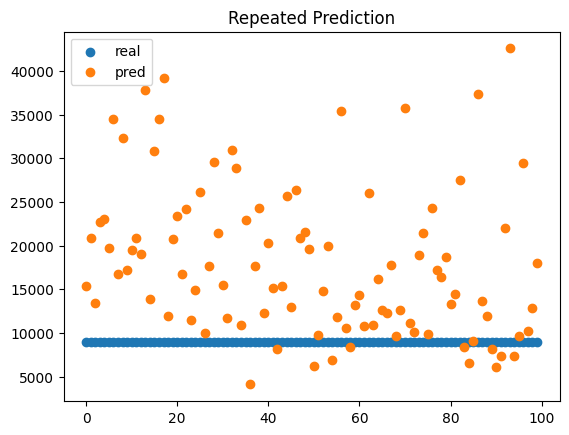

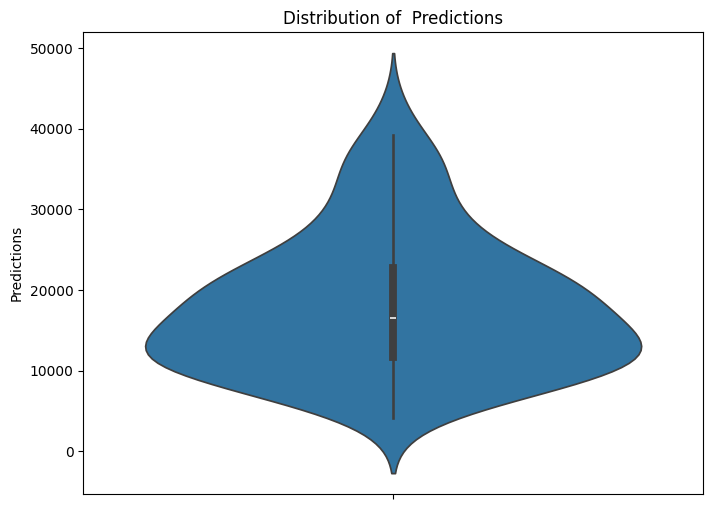

real: shape: torch.Size([100]), goal val: 8963.0
min: 4093.0, max: 42561.0, mean: 18042.48046875, std: 8561.234375


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# TODO good enough for now
device = 'cpu'

# Generate text
output = model_for_trainer.generate(
    eval_dataset[0]['input_ids'].unsqueeze(0),
    # max_length=512,
    max_new_tokens=1,
    # temperature=0.7,
    # num_return_sequences=1,
    # pad_token_id=vocab_size - 1,
    # do_sample=True
)

torch.set_printoptions(profile='full')
print('start')
print('real',eval_dataset[0]['labels'][:32])
print('pred',output[0][1:33])
print('middle (1020:1050)')
print('real',eval_dataset[0]['labels'][1000:1050])
print('pred',output[0][1001:1051])
print('end')
print('real',eval_dataset[0]['labels'][-32:])
print('pred',output[0][-32:])
torch.set_printoptions(profile='default')

# create scatter plot
n = 100
m = 1

# not sure how to line up the real and pred when using different size. so i will just change dataset size
real = torch.full_like(torch.zeros(n), eval_dataset[0]['labels'][-1])
pred = torch.zeros(n)

pbar = tqdm(range(0, n, m), total=n)
for i in pbar:
    output = model_for_trainer.generate(
        eval_dataset[0]['input_ids'][:block_size].unsqueeze(0),
        max_new_tokens=1,
    )

    for j in range(m): # -1
        pred[i+j] = output[j][-1].cpu() # have to do this to get the value
    pbar.update(m)

# create scatter plot
plt.scatter(range(n), real, label='real')
plt.scatter(range(n), pred, label='pred')
plt.title('Repeated Prediction')
plt.legend()
plt.show()

df = pd.DataFrame({'Predictions': pred})

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(y='Predictions', data=df)
plt.title(f"Distribution of  Predictions")
plt.show()

print(f"real: shape: {real.shape}, goal val: {real[0]}")
print(f"min: {min(pred)}, max: {max(pred)}, mean: {torch.mean(pred)}, std: {torch.std(pred)}")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.37it/s]


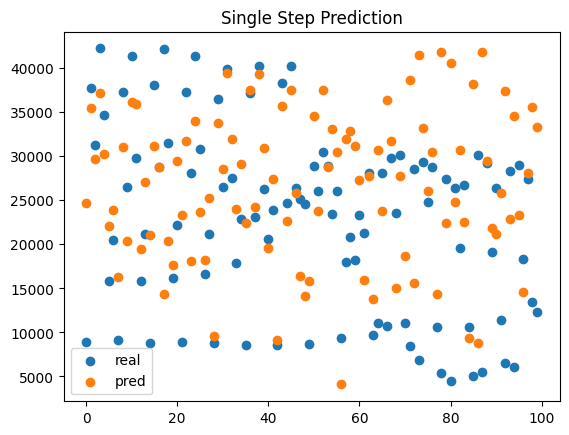

In [15]:
# create scatter plot
n = 100
m = 1

if n >= len(eval_dataset)-1:
    n = len(eval_dataset)-1

# not sure how to line up the real and pred when using different size. so i will just change dataset size
real = torch.zeros(n)
pred = torch.zeros(n)

pbar = tqdm(range(0, n, m), total=n)
for i in pbar:
    output = model_for_trainer.generate(
        eval_dataset[i]['input_ids'][:block_size].unsqueeze(0),
        max_new_tokens=1,
    )

    for j in range(m): # -1
        real[i+j] = eval_dataset[i]['labels'][-1]
        pred[i+j] = output[j][-1].cpu() # have to do this to get the value
    pbar.update(m)

# create scatter plot
plt.scatter(range(n), real, label='real')
plt.scatter(range(n), pred, label='pred')
plt.title('Single Step Prediction')
plt.legend()
plt.show()

In [16]:
mse = torch.mean((real - pred) ** 2)
print(mse)

tensor(1.5769e+08)


In [17]:
# sim percent
max_diff = torch.max(torch.abs(real))  # Maximum possible difference
mae = torch.mean(torch.abs(real - pred))

print(100 * (1 - mae/max_diff))

tensor(79.8200)


In [18]:
# TODO cant do this, because they have different norms
test_dataset = GPTDataset(files=['etth1-clean-test.csv'], window=block_size+64, samples_per_file=1, normalize=False)

max samples from file
samples: 1


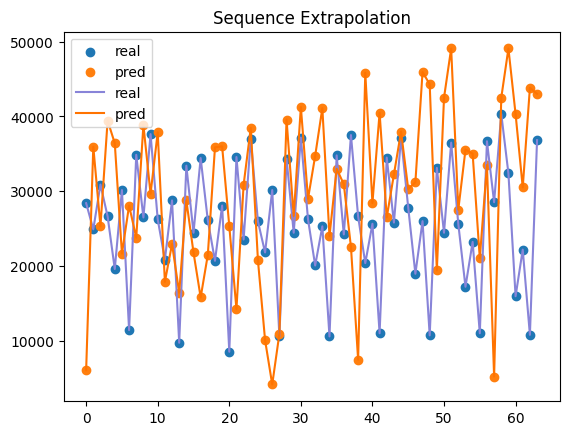

In [19]:
output = model_for_trainer.generate(
    test_dataset[0]['input_ids'][:block_size].unsqueeze(0),
    max_new_tokens=64,
)

# create scatter plot
plt.scatter(range(64), test_dataset[0]['labels'][-64:], label='real')
plt.scatter(range(64), output[0][block_size:], label='pred')
plt.plot(range(64), test_dataset[0]['labels'][-64:], label="real", color='#8884d8')
plt.plot(range(64), output[0][block_size:], label="pred", color='#ff7300')
plt.title('Sequence Extrapolation')
plt.legend()
plt.show()

,i,real,pred-0,loss-0,pred-1,loss-1,pred-2,loss-2
0,0,28395.0,24351.0,0.142419,37327.0,0.239291,15316.0,0.460609
1,1,24901.0,30844.0,0.192679,27033.0,0.078867,25303.0,0.015887
2,2,30893.0,9175.0,0.703007,22091.0,0.284919,14257.0,0.538504
3,3,26628.0,11771.0,0.557947,28750.0,0.073809,19696.0,0.260327
4,4,19596.0,30978.0,0.367422,41079.0,0.522968,34850.0,0.437704
5,5,30150.0,21495.0,0.287065,18491.0,0.386700,28920.0,0.040796
6,6,11434.0,28762.0,0.602462,25645.0,0.554143,21833.0,0.476297
7,7,34858.0,9387.0,0.730707,28656.0,0.177922,12140.0,0.651730
8,8,26486.0,28762.0,0.079132,27727.0,0.044758,23072.0,0.128898
9,9,37628.0,20798.0,0.447273,24951.0,0.336903,26691.0,0.290661


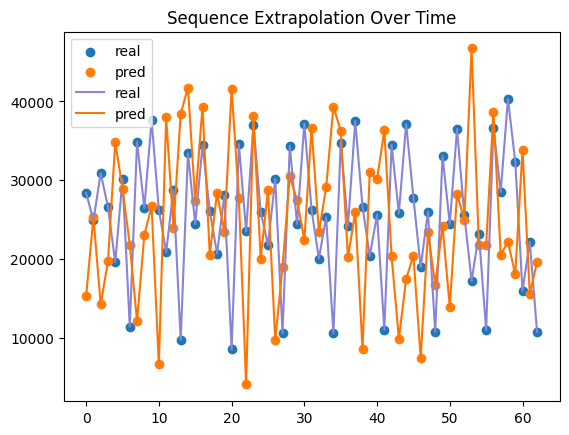

In [20]:
# # go as far as we can

real = torch.zeros(block_size+64-1)
pred = torch.zeros(block_size+64-1)
input_ids = test_dataset[0]['input_ids'][:block_size]

# could do it this way, or keep calling it with the last block i:i+block_size
i = 0
err = 0
overs = []
df_over = pd.DataFrame(columns=['i', 'real', 'pred-0', 'loss-0', 'pred-1', 'loss-1', 'pred-2', 'loss-2'])
display_handle = display(df_over, display_id=True)
while err < 0.2 and i < 64-1:
    # print(i, end=': ')
    real[i] = test_dataset[0]['labels'][block_size+i-1]
    over = {'i': i, 'real': real[i].item() }
    for j in range(3):
        output = model_for_trainer.generate(
            input_ids.unsqueeze(0),
            max_new_tokens=1,
        )

        pred[i] = output[0].cpu()[-1]
        # print(label, out)
        # Calculate relative error as |real - pred| / max(|real|, |pred|)
        # This handles cases where real or pred could be zero or very different magnitudes
        numerator = torch.abs(real[i] - pred[i])
        denominator = torch.maximum(torch.abs(real[i]), torch.abs(pred[i]))
        # Add small epsilon to prevent division by zero if both values are 0
        epsilon = 1e-10
        relative_error = numerator / (denominator + epsilon)
        # print(real[i], pred[i], end=' ')
        # print(relative_error, end='\t')
        over[f"pred-{j}"] = pred[i].item()
        over[f"loss-{j}"] = relative_error.item()

    input_ids = torch.cat((input_ids[1:], pred[i].long().unsqueeze(0)))
    # print()
    overs.append(over)
    df_over = pd.DataFrame(overs)

    # bad to keep it, but its the last one
    pd.set_option('display.max_rows', None)
    display_handle.update(df_over)
    
    i+=1

# create scatter plot
plt.scatter(range(i), real[:i], label='real')
plt.scatter(range(i), pred[:i], label='pred')
plt.plot(range(i), real[:i], label="real", color='#8884d8')
plt.plot(range(i), pred[:i], label="pred", color='#ff7300')
plt.title('Sequence Extrapolation Over Time')
plt.legend()
plt.show()

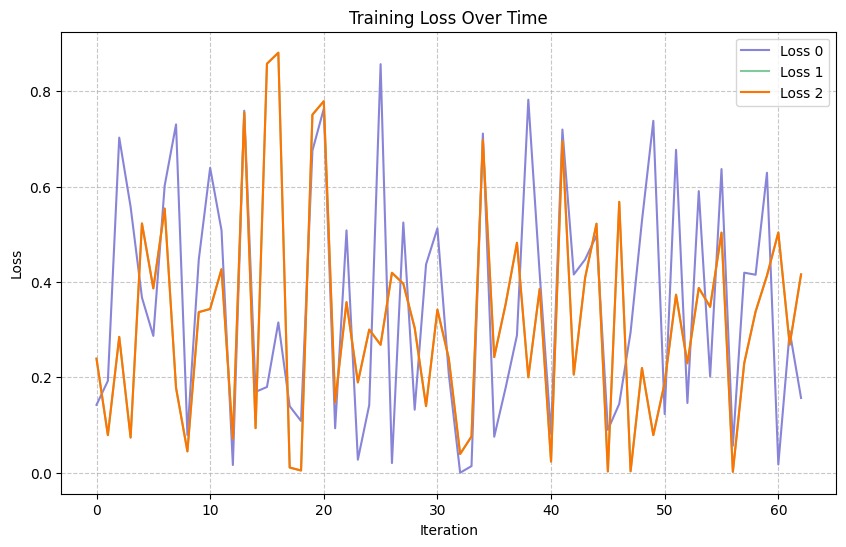

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_over['i'], df_over['loss-0'], label=f"Loss 0", color='#8884d8')
plt.plot(df_over['i'], df_over['loss-1'], label=f"Loss 1", color='#82ca9d')
plt.plot(df_over['i'], df_over['loss-1'], label=f"Loss 2", color='#ff7300')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()